In [1]:
import copy
import os
import re
import shutil
import sys
from pathlib import Path

import numpy as np
import tifffile
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.data.multiplex as multiplex
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.cosmx as cosmx
import mushroom.data.he as he
import mushroom.data.user_points as points
import mushroom.registration.bigwarp as bigwarp
import mushroom.utils as utils

In [5]:
project_dir = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1'
Path(project_dir).mkdir(parents=True, exist_ok=True)

In [6]:
# specifying a channel in multiplex imaging sections to use during registration/visualization
multiplex_channel = 'DAPI'

# scale factors for registration
# each data type identifier will be downsampled by {default_scale}, or scale specified in {dtype_to_scale} (bigwarp registration can be cumbersome with large, full resolution images)
# this scale factor DOES NOT downsample data input to mushroom, mushroom inputs will still be full resolution. It is purely to get bigwarp to run more smoothly.
# here we just downsample every data type by 20%
default_scale = .2

# if you wanted a specific data type to be scaled more or less than other data types, you could specify here
dtype_to_scale = {
#     'multiplex': .1, # for example, if you uncommented this line multiplex data would be scaled by .1 instead of .2
}

## Define inputs

###### S18-9906

In [249]:
case = 'S18-9906'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(project_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'S18-9906-U2',
    'resolution': None,
    'sections': [
        {
            'sid': 'S18-9906-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S18-9906/B27/S18-9906-B27Us1_1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_S18-9906-B27Us1_1.tif'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010784__S18-9906-B27Us1_2Q1__20230912__220421'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U3',
            'position': 10,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U3__20231006.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U9',
            'position': 40,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010787__S18-9906-B27Us1_9Q1__20230912__220421'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U10',
            'position': 45,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U10__20231006.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U16',
            'position': 105,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S18-9906/B27/S18-9906-B27Us1_16Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_S18-9906-B27Us1_16.tif'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U17',
            'position': 120,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010784__S18-9906-B27Us1_17Q1__20230912__220421'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U18',
            'position': 125,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U18__20231006.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U24',
            'position': 155,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010787__S18-9906-B27Us1_24Q1__20230912__220421'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U25',
            'position': 160,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U25__20231006.ome.tiff'
                }
            ]
        }
    ]
}


###### HT397B1

In [47]:
case = 'HT397B1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(project_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT397B1-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT397B1-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT397B1/S1H3/HT397B1-S1H3A1U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_HT397B1-S1H3A1U1.tif'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/031623_BRCA_HT397B1-U2/HT397B1-S1H3A1-U2__20230315.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U12',
            'position': 55,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/03172023_BRCA_HT397B1-U12/HT397B1-S1H3A1-U22__20230316.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U21',
            'position': 100,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT397B1/S1H3/HT397B1-S1H3A1U21Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT397B1-S1H3A1U21.tif'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U22',
            'position': 105,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/041223_BRCA_HT397B1-S1H3A1-U22/HT397B1-S1H3A1-U22__20230413.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U31',
            'position': 150,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/040623_BRCA_HT397B1-U31/HT397B1-S1H3A1-U31__20230407.ome.tiff'
                },
            ] 
        },
    ]
}


###### HT413C1-Th1k4A1

In [8]:
case = 'HT413C1-Th1k4A1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(project_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT413C1-Th1k4A1-U19',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT413C1-Th1k4A1-U14',
            'position': 0,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U14.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U18',
            'position': 20,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U18.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U19',
            'position': 25,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium_primary/data/20240116__200025__24019/output-XETG00122__0010369__HT413C1-Th1K4A1Us1_19__20240116__200059'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U20',
            'position': 30,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240110_Human_mCRC_Serial_section_HT413C1_Th1k4A1_Slide3/HT413C1_Th1k4A1_U20__20240110.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U1',
            'position': 45,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U1.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U2',
            'position': 50,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium_primary/data/20240116__200025__24019/output-XETG00122__0010369__HT413C1-Th1K4A1Us1_2__20240116__200059'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U3',
            'position': 55,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240110_Human_mCRC_Serial_section_HT413C1_Th1k4A1_Slide3/HT413C1_Th1k4A1_U3__20240110.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U4',
            'position': 60,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U4.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U7',
            'position': 75,
            'data': [
                {
                    'dtype': 'cosmx',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/cosmx/HT413C1-Th1K4A1Us7_1.h5ad'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U8',
            'position': 80,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U8.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U9',
            'position': 85,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium_primary/data/20240116__200025__24019/output-XETG00122__0010378__HT413C1-Th1K4A1Us1_9__20240116__200059'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U11',
            'position': 95,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U11.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U21',
            'position': 100,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U21.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U24',
            'position': 115,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U24.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U25',
            'position': 120,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium_primary/data/20240116__200025__24019/output-XETG00122__0010378__HT413C1-Th1K4A1Us1_25__20240116__200059'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U26',
            'position': 125,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240111_Human_mCRC_serial_sectrion_HT413C1_Th1k4A1_Slide_8/HT413C1_Th1k4A1_U26__20240111.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U27',
            'position': 130,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U27.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U29',
            'position': 140,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U29.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U30',
            'position': 145,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U30.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U31',
            'position': 150,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium_primary/data/20240116__200025__24019/output-XETG00122__0010369__HT413C1-Th1K4A1Us1_31__20240116__200059'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U32',
            'position': 155,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240110_Human_mCRC_Serial_section_HT413C1_Th1k4A1_Slide3/HT413C1_Th1k4A1_U32__20240110.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U34',
            'position': 165,
            'data': [
                {
                    'dtype': 'cosmx',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/cosmx/HT413C1-Th1K4A1Us34_1.h5ad'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U35',
            'position': 170,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U35.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U36',
            'position': 175,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium_primary/data/20240116__200025__24019/output-XETG00122__0010378__HT413C1-Th1K4A1Us1_36__20240116__200059'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U37',
            'position': 180,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240111_Human_mCRC_serial_sectrion_HT413C1_Th1k4A1_Slide_8/HT413C1_Th1k4A1_U37__20240111.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U38',
            'position': 185,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U38.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U40',
            'position': 195,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U40.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U41',
            'position': 200,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240110_Human_mCRC_Serial_section_HT413C1_Th1k4A1_Slide3/HT413C1_Th1k4A1_U41__20240110.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U42',
            'position': 205,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240111_Human_mCRC_serial_sectrion_HT413C1_Th1k4A1_Slide_8/HT413C1_Th1k4A1_U42__20240111.ome.tiff'
                },
            ] 
        }, 
    ]
}


###### S18-25943-A7

In [67]:
case = 'S18-25943-A7'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'S18-25943-A7-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'S18-25943-A7-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231117__205826__24011/output-XETG00122__0011123__S18-25943-A7Us1_1__20231117__205842'
                },
            ] 
        },
#         { cut off
#             'sid': 'S18-25943-A7-U2',
#             'position': 5,
#             'data': [
#                 {
#                     'dtype': 'multiplex',
#                     'filepath': '/diskmnt/primary/CODEX/HTAN/20231122_Human_pancreatic_cancer_S18-25943-A7Us1_2__Us1_9__Us1_13__Us1_16/S18-25943-U2__20231122.ome.tiff
# '
#                 },
#             ] 
#         },
        {
            'sid': 'S18-25943-A7-U4',
            'position': 15,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231117__205826__24011/output-XETG00122__0011128__S18-25943-A7Us1_4__20231117__205843'
                },
            ] 
        },
        {
            'sid': 'S18-25943-A7-U8',
            'position': 35,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231117__205826__24011/output-XETG00122__0011123__S18-25943-A7Us1_8__20231117__205843'
                },
            ] 
        },
        {
            'sid': 'S18-25943-A7-U9',
            'position': 40,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231122_Human_pancreatic_cancer_S18-25943-A7Us1_2__Us1_9__Us1_13__Us1_16/S18-25943-U9__20231122.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-25943-A7-U11',
            'position': 50,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231117__205826__24011/output-XETG00122__0011128__S18-25943-A7Us1_11__20231117__205843'
                },
            ] 
        },
        {
            'sid': 'S18-25943-A7-U13',
            'position': 60,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231122_Human_pancreatic_cancer_S18-25943-A7Us1_2__Us1_9__Us1_13__Us1_16/S18-25943-U13__20231122.ome.tiff'
                },
            ] 
        },
#         {
#             'sid': 'S18-25943-A7-U16',
#             'position': 75,
#             'data': [
#                 {
#                     'dtype': 'multiplex',
#                     'filepath': '/diskmnt/primary/CODEX/HTAN/20231122_Human_pancreatic_cancer_S18-25943-A7Us1_2__Us1_9__Us1_13__Us1_16/S18-25943-U16__20231122.ome.tiff'
#                 },
#             ] 
#         },
    ]
}


###### HT206B1

In [93]:
case = 'HT206B1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT206B1-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT206B1-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230919__220553__24003/output-XETG00122__0010520__HT206B1-H2L1Us1_8__20230919__220650'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20230914_BRCA_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U2__20230914.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U5',
            'position': 20,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U5__20231002.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U8',
            'position': 40,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230830__153957__20230830_24001/output-XETG00122__0010528__HT206B1-H2L1Us1_17__20230830__154053'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U9',
            'position': 45,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230919__220553__24003/output-XETG00122__0010520__HT206B1-H2L1Us1_15__20230919__220650'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U10',
            'position': 50,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20230914_BRCA_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U10__20230914.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U13',
            'position': 65,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U13__20231002.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U16',
            'position': 80,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230830__153957__20230830_24001/output-XETG00122__0010528__HT206B1-H2L1Us1_9__20230830__154053'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U17',
            'position': 85,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230919__220553__24003/output-XETG00122__0010520__HT206B1-H2L1Us1_24__20230919__220650'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U18',
            'position': 90,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20230914_BRCA_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U18__20230914.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U21',
            'position': 105,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U21__20231002.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U24',
            'position': 120,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230830__153957__20230830_24001/output-XETG00122__0010528__HT206B1-H2L1Us1_1__20230830__154053'
                },
            ] 
        },
    ]
}


###### HT225C1

In [275]:
case = 'HT225C1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT225C1-U2',
    'resolution': None,
    'sections': [
#         { is too far away
#             'sid': 'HT225C1-U1',
#             'position': 0,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT225C1/H1/HT225C1-Th1Fc1U1Z1B1/outs'
#                 },
#             ] 
#         },
        {
            'sid': 'HT225C1-U2',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT225C1/H1/HT225C1-Th1Fc1U2Z1B1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/20201124_HT225C1-Th1Fc1U2.tif',
                }
            ] 
        },
        {
            'sid': 'HT225C1-U3',
            'position': 60,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT225C1/H1/HT225C1-Th1Fc1U3Z1B1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/20201124_HT225C1-Th1Fc1U3.tif',
                }
            ] 
        },
        {
            'sid': 'HT225C1-U4',
            'position': 120,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT225C1/H1/HT225C1-Th1Fc1U4Z1B1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/20201124_HT225C1-Th1Fc1U4.tif',
                }
            ] 
        },
        {
            'sid': 'HT225C1-U5',
            'position': 180,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT225C1/H1/HT225C1-Th1Fc1U5Z1B1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/20201124_HT225C1-Th1Fc1U5.tif',
                }
            ] 
        },
    ]
}


###### HT268B1

In [285]:
case = 'HT268B1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT268B1-U2',
    'resolution': None,
    'sections': [
#         { avoiding batch effects
#             'sid': 'HT268B1-U1',
#             'position': 0,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT268B1/H1/HT268B1-Th1K3Fc2U1Z1Bs1/outs'
#                 },
#             ] 
#         },
        {
            'sid': 'HT268B1-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT268B1/Th1H3/HT268B1-Th1H3Fc2U2Z1Bs1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_HT268B1-Th1H3Fc2U2.tif',
                },
            ] 
        },
        {
            'sid': 'HT268B1-U12',
            'position': 55,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT268B1/Th1H3/HT268B1-Th1H3Fc2U12Z1Bs1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT268B1-Th1H3Fc2U12.tif',
                },
            ] 
        },
        {
            'sid': 'HT268B1-U22',
            'position': 105,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT268B1/Th1H3/HT268B1-Th1H3Fc2U22Z1Bs1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT268B1-Th1H3Fc2U22.tif',
                },
            ] 
        },
        {
            'sid': 'HT268B1-U32',
            'position': 155,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT268B1/Th1H3/HT268B1-Th1H3Fc2U32Z1Bs1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_HT268B1-Th1H3Fc2U32.tif',
                },
            ] 
        },
    ]
}


###### S18-5591-C8

In [190]:
case = 'S18-5591-C8'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'S18-5591-C8-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'S18-5591-C8-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231114__223057__24010/output-XETG00122__0011055__S18-5591-C8Us2_1__20231114__223131'
                },
            ] 
        },
#         {
#             'sid': 'S18-5591-C8-U2',
#             'position': 0,
#             'data': [
#                 {
#                     'dtype': 'multiplex',
#                     'filepath': '/diskmnt/primary/CODEX/HTAN/20231116_Human_prostate_African_American_serial_S18_5591_Slide_2/S18-5591-U2__20231116.ome.tiff'
#                 },
#             ] 
#         },
        {
            'sid': 'S18-5591-C8-U5',
            'position': 20,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231114__223057__24010/output-XETG00122__0010977__S18-5591-C8Us2_5__20231114__223131'
                },
            ] 
        },
#         {
#             'sid': 'S18-5591-C8-U6',
#             'position': 0,
#             'data': [
#                 {
#                     'dtype': 'multiplex',
#                     'filepath': '/diskmnt/primary/CODEX/HTAN/20231118_Human_prostate_African_American_serial_S18_5591_Slide_6/S18-5591-U6__20231118.ome.tiff'
#                 },
#             ] 
#         },
        {
            'sid': 'S18-5591-C8-U7',
            'position': 30,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231114__223057__24010/output-XETG00122__0011055__S18-5591-C8Us2_7__20231114__223131'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U8',
            'position': 35,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231116_Human_prostate_African_American_serial_S18_5591_Slide_2/S18-5591-U8__20231116.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U12',
            'position': 55,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231114__223057__24010/output-XETG00122__0010977__S18-5591-C8Us2_12__20231114__223131'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U14',
            'position': 65,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231118_Human_prostate_African_American_serial_S18_5591_Slide_6/S18-5591-U14__20231118.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U18',
            'position': 85,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231114__223057__24010/output-XETG00122__0011055__S18-5591-C8Us2_18__20231114__223131'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U19',
            'position': 90,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231116_Human_prostate_African_American_serial_S18_5591_Slide_2/S18-5591-U19__20231116.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U20',
            'position': 95,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231114__223057__24010/output-XETG00122__0010977__S18-5591-C8Us2_20__20231114__223131'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U21',
            'position': 100,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231118_Human_prostate_African_American_serial_S18_5591_Slide_6/S18-5591-U21__20231118.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U23',
            'position': 110,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231116_Human_prostate_African_American_serial_S18_5591_Slide_2/S18-5591-U23__20231116.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U24',
            'position': 115,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231118_Human_prostate_African_American_serial_S18_5591_Slide_6/S18-5591-U24__20231118.ome.tiff'
                },
            ] 
        },
    ]
}


###### C3L-00982

In [219]:
case = 'C3L-00982'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)


data_map = {
    'target_sid': 'C3L-00982-U2',
    'resolution': None,
    'sections': [
        {
            'sid': 'C3L-00982-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240117-C3L-00982-11/C3L-00982-11_U1__20240117.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'C3L-00982-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240202__180839__20240202_Ding_RCC/output-XETG00063__0025152__C3L-00982-11U2__20240202__180855'
                },
            ] 
        },
        {
            'sid': 'C3L-00982-U4',
            'position': 15,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240117-C3L-00982-11/C3L-00982-11_U4__20240117.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'C3L-00982-U7',
            'position': 30,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240117-C3L-00982-11/C3L-00982-11_U7__20240117.ome.tiff'
                },
            ] 
        },
    ]
}


###### C3L-02551

In [234]:
case = 'C3L-02551'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'C3L-02551-U3',
    'resolution': None,
    'sections': [
        {
            'sid': 'C3L-02551-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240118-C3L-02551-11/C3L-02551-11_U1__20240118.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'C3L-02551-U3',
            'position': 10,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240202__180839__20240202_Ding_RCC/output-XETG00063__0025152__C3L-02551-11U3__20240202__180855'
                },
            ] 
        },
        {
            'sid': 'C3L-02551-U4',
            'position': 15,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240118-C3L-02551-11/C3L-02551-11_U4__20240118.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'C3L-02551-U8',
            'position': 35,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240118-C3L-02551-11/C3L-02551-11_U8__20240118.ome.tiff'
                },
            ] 
        },
    ]
}


###### C3L-00970

In [390]:
case = 'C3L-00970'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'C3L-00970-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'C3L-00970-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231221__194124__24015/output-XETG00122__0010024__C3L-00970-13U1__20231221__194156'
                },
            ] 
        },
        {
            'sid': 'C3L-00970-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231220_Human_CCRCC_C3L-00970-13u2_top_C3N-00733-12U2-PA00002352U1_Btom/C3L-00970-13u2__20231220.ome.tiff'
                },
            ] 
        },
#         { # too far away to register
#             'sid': 'C3L-00970-U3',
#             'position': 0,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/C3L-00970/13/C3L-00970-13U3Bp1/outs'
#                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_C3L-00970-13U3.tif'
#                 },
#             ] 
#         },
    ]
}


###### C3L-01287

In [412]:
case = 'C3L-01287'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'C3L-01287-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'C3L-01287-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231130__221907__24012/output-XETG00122__0010350__C3L-01287-11Us1_1__20231130__221933'
                },
            ] 
        },
        {
            'sid': 'C3L-01287-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231219_Human_CCRCC_C3L-01287-11Us1_2_top_C3N-01200-11Us1_2_middle_C3N-01200-13-U2_btm/C3L-01287-11Us1__20231219.ome.tiff'
                },
            ] 
        },
#         { # too far away to register
#             'sid': 'C3L-01287-U3',
#             'position': 10,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/C3L-01287/11/C3L-01287-11U3Bp1/outs'
#                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_C3L-01287-11U3.tif'
#                 },
#             ] 
#         },
    ]
}


###### HT413C1-K2

In [428]:
case = 'HT413C1-K2'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

# visium are farther apart than indicated by section numbers, also avoiding last two visium bc of tears

data_map = {
    'target_sid': 'HT413C1-K2-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT413C1-K2-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT413C1/Th1K2/HT413C1-Th1K2A4U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_HT413C1-Th1K2A4U1.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-K2-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/HT413C1-K2__20230427.ome.tiff'
                }
            ]
        }
#         {
#             'sid': 'HT413C1-K2-U11',
#             'position': 50,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT413C1/Th1K2/HT413C1-Th1K2A4U2Bp1/outs'
#                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_HT413C1-Th1K2A4U2.tif'
#                 },
#             ] 
#         },
#         {
#             'sid': 'HT413C1-K2-U24',
#             'position': 100,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT413C1/Th1K2/HT413C1-Th1K2A4U14Bp1/outs'
#                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT413C1-Th1K2A4U14.tif'
#                 },
#             ] 
#         },
        
#         {
#             'sid': 'HT413C1-K2-Us1K1',
#             'position': 4,
#             'data': [
# #                 {
# #                     'dtype': 'visium',
# #                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT413C1/Th1K1A4/HT413C1-Th1K1A4Us1_3Bp1/outs'
# #                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_HT413C1-Th1K1A4Us1_3.tif'
#                 },
#             ] 
#         },
#         {
#             'sid': 'HT413C1-K2-Us1K2',
#             'position': 5,
#             'data': [
# #                 {
# #                     'dtype': 'visium',
# #                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT413C1/Th1K2A1/HT413C1-Th1K2A1Us1_2Bp1/outs'
# #                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT413C1-Th1K2A1Us1_2.tif'
#                 },
#             ] 
#         },
#         {
#             'sid': 'HT413C1-K2-Us1K3',
#             'position': 6,
#             'data': [
# #                 {
# #                     'dtype': 'visium',
# #                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT413C1/Th1K3A1/HT413C1-Th1K3A1Us1_1Bp1/outs'
# #                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT413C1-Th1K3A1Us1_1.tif'
#                 },
#             ] 
#         },
    ]
}


###### HT339B2-H1

In [445]:
case = 'HT339B2-H1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT339B2-H1-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT339B2-H1-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT339B2/H1/HT339B2-H1Fp1U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT339B2-H1Fp1U1.tif'
                }
            ] 
        },
        {
            'sid': 'HT339B2-H1-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/HT339B2-H1__20230427.ome.tiff'
                }
            ] 
        },
    ]
}


###### HT553P1-H2

In [459]:
case = 'HT553P1-H2'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

# /diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT553P1-S1H2Fp1U1.tif
# /diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT553P1/S1H2/HT553P1-S1H2Fp1U1Bp1

# /diskmnt/primary/CODEX/HTAN/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/HT553P1-H2__20230427.ome.tiff

data_map = {
    'target_sid': 'HT553P1-H2-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT553P1-H2-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT553P1/S1H2/HT553P1-S1H2Fp1U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT553P1-S1H2Fp1U1.tif'
                },
            ] 
        },
        {
            'sid': 'HT553P1-H2-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/HT553P1-H2__20230427.ome.tiff'
                },
            ] 
        },
    ]
}


###### HT565B1-H2

In [473]:
case = 'HT565B1-H2'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT565B1-H2-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT565B1-H2-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT565B1/S1H2/HT565B1-S1H2Fp2U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_HT565B1-S1H2Fp2U1.tif'
                },
            ] 
        },
        {
            'sid': 'HT565B1-H2-U2',
            'position': 0,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/HT565B1-H2__20230427.ome.tiff'
                },
            ] 
        },
    ]
}


###### HT308B1-S1H5A4 (not actually using, too far away)

In [487]:
# case = 'HT308B1-S1H5A4'
# reg_dir = os.path.join(project_dir, case, 'registration')
# Path(reg_dir).mkdir(parents=True, exist_ok=True)

# # /diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT308B1/H5/HT308B1-S1H5Fc2U1Z1Bs1/
# # /diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT308B1/H5/HT308B1-S2H5Fc2U1Z1Bs1/

# # /diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT308B1-S1H5Fc2U1.tif
# # /diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT308B1-S2H5Fc2U1.tif

# # /diskmnt/primary/CODEX/HTAN/20220217-HT308B1-H5A4/HT308B1-H5A4__20220217.ome.tiff
# # /diskmnt/primary/CODEX/HTAN/MouseMarrow-179_BRCA-HT308B1/HT308B1__20221112.ome.tiff
# # /diskmnt/primary/CODEX/HTAN/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/HT308B1-S1H5A4_left__20230512.ome.tiff
# # /diskmnt/primary/CODEX/HTAN/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/HT308B1-S1H5A4_right__20230512.ome.tiff
# # /diskmnt/primary/CODEX/HTAN/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/HT308B1-S1H5A4_left__20230526.ome.tiff
# # /diskmnt/primary/CODEX/HTAN/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/HT308B1-S1H5A4_right__20230526.ome.tiff
# # /diskmnt/primary/CODEX/HTAN/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/HT308B1-S1H5A4__20230420.ome.tiff


# # data_map = {
# #     'target_sid': 'HT308B1-S1H5A4-Ua',
# #     'resolution': None,
# #     'sections': [
# #         {
# #             'sid': 'HT308B1-S1H5A4-Ua',
# #             'position': 0,
# #             'data': [
# #                 {
# #                     'dtype': 'visium',
# #                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT308B1/H5/HT308B1-S1H5Fc2U1Z1Bs1/outs'
# #                 },
# #                 {
# #                     'dtype': 'he',
# #                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT308B1-S1H5Fc2U1.tif'
# #                 },
# #             ] 
# #         },
# #         {
# #             'sid': 'HT308B1-S1H5A4-Ub',
# #             'position': 0,
# #             'data': [
# #                 {
# #                     'dtype': 'he',
# #                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT308B1-S2H5Fc2U1.tif'
# #                 },
# #             ] 
# #         },
# #         {
# #             'sid': 'HT308B1-S1H5A4-Uc',
# #             'position': 0,
# #             'data': [
# #                 {
# #                     'dtype': 'multiplex',
# #                     'filepath': '/diskmnt/primary/CODEX/HTAN/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/HT308B1-S1H5A4_left__20230512.ome.tiff'
# #                 },
# #             ] 
# #         },
# #         {
# #             'sid': 'HT308B1-S1H5A4-Ud',
# #             'position': 0,
# #             'data': [
# #                 {
# #                     'dtype': 'multiplex',
# #                     'filepath': '/diskmnt/primary/CODEX/HTAN/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/HT308B1-S1H5A4_right__20230526.ome.tiff'
# #                 },
# #             ] 
# #         },
# #         {
# #             'sid': 'HT308B1-S1H5A4-Uf',
# #             'position': 0,
# #             'data': [
# #                 {
# #                     'dtype': 'multiplex',
# #                     'filepath': '/diskmnt/primary/CODEX/HTAN/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/HT308B1-S1H5A4__20230420.ome.tiff'
# #                 },
# #             ] 
# #         },
# #     ]
# # }
# data_map = {
#     'target_sid': 'HT308B1-S1H5A4-U1',
#     'resolution': None,
#     'sections': [
#         {
#             'sid': 'HT308B1-S1H5A4-U1',
#             'position': 0,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT308B1/H5/HT308B1-S1H5Fc2U1Z1Bs1/outs'
#                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT308B1-S1H5Fc2U1.tif'
#                 },
#             ] 
#         },
#         {
#             'sid': 'HT308B1-S1H5A4-U2',
#             'position': 5,
#             'data': [
#                 {
#                     'dtype': 'multiplex',
#                     'filepath': '/diskmnt/primary/CODEX/HTAN/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/HT308B1-S1H5A4__20230420.ome.tiff'
#                 },
#             ] 
#         },
#     ]
# }



###### HT397B1-H2A2 (not using, too far)

In [494]:
case = 'HT397B1-H2A2'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

# /diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_HT397B1-S1H2A4.tif
# /diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT397B1/H2/HT397B1-S1H2Fs4U1Bp1

# /diskmnt/primary/CODEX/HTAN/20220505-HT397B1-H2A2/HT397B1-H2A2__20220505.ome.tiff

data_map = {
    'target_sid': 'HT397B1-H2A2-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT397B1-H2A2-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT397B1/H2/HT397B1-S1H2Fs4U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_HT397B1-S1H2A4.tif'
                },
            ] 
        },
        {
            'sid': 'HT397B1-H2A2-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20220505-HT397B1-H2A2/HT397B1-H2A2__20220505.ome.tiff'
                },
            ] 
        },
    ]
}


###### HT397B1-H3A1 (not using, too far)

In [501]:
case = 'HT397B1-H3A1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT397B1-H3A1-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT397B1-H3A1-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT397B1/H3/HT397B1-S1H3Fs1U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT397B1-S1H3A1.tif'
                },
            ] 
        },
        {
            'sid': 'HT397B1-H3A1-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20220429-HT397B1-H3A1/HT397B1-H3A1__20220429.ome.tiff'
                },
            ] 
        },
    ]
}


###### HT323B1-S1H3A4 (not using, too far)

In [504]:
case = 'HT323B1-S1H3A4'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT323B1-S1H3A4-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT323B1-S1H3A4-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT323B1/H3/HT323B1-S1H3Fc2U1Z1Bs1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT323B1-S1H3Fc2U1.tif'
                },
            ] 
        },
#         {
#             'sid': 'HT323B1-S1H3A4-U2',
#             'position': 5,
#             'data': [
#                 {
#                     'dtype': 'multiplex',
#                     'filepath': '/diskmnt/primary/CODEX/HTAN/20220211-HT323B1-H3/HT323B1-H3__20220211.ome.tiff'
#                 },
#             ] 
#         },
        {
            'sid': 'HT323B1-S1H3A4-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20211008_HT323B1-S1H3A4/HT323B1-S1H3A4__20211008.ome.tiff'
                },
            ] 
        },
    ]
}


###### S15-32775-Met (not using, too far)

In [511]:
case = 'S15-32775-Met'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'S15-32775-Met-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'S15-32775-Met-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S15-32775/A1/S15-32775-A1U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_S15-32775-A1U1.tif'
                },
            ] 
        },
        {
            'sid': 'S15-32775-Met-U2',
            'position': 0,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20230826_mCRC_S16-32775_Primary_and_Met/mCRC_S16-32775_Met__20230826.ome.tiff'
                },
            ] 
        },
    ]
}


###### S16-38794-Primary (not using, too far)

In [518]:
case = 'S16-38794-Primary'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)
data_map = {
    'target_sid': 'S16-38794-Primary-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'S16-38794-Primary-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S16-38794/A3/S16-38794-A3U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_S16-38794-A3U1.tif'
                },
            ] 
        },
        {
            'sid': 'S16-38794-Primary-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20230824_mCRC_S16-38794_Primary/mCRC_S16-38794_Primary__20230824.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S16-38794-Primary-U3',
            'position': 10,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240112__230030__20240112_24018_8UTB89_retry/output-XETG00122__0010375__S16-38794-A3U2__20240112__230102'
                },
            ] 
        },
    ]
}


###### S16-38794-Met (not using, too far)

In [348]:
case = 'S16-38794-Met'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)


data_map = {
    'target_sid': 'S16-38794-Met-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'S16-38794-Met-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S16-38794/E3/S16-38794-E3U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_S16-38794-E3U1.tif'
                },
            ] 
        },
        {
            'sid': 'S16-38794-Met-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/08232023_mCRC_S16-38794_Met/mCRC_S16-38794_Met__20230823.ome.tiff'
                },
            ] 
        },
    ]
}


###### S15-1909-C2 (not using, too far)

In [525]:
case = 'S15-1909-C2'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)


data_map = {
    'target_sid': 'S15-1909-C2-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'S15-1909-C2-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S15-1909/C2/S15-1909-C2U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_S15-1909-C2U1.tif'
                },
            ] 
        },
        {
            'sid': 'S15-1909-C2-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20230309_CRC_Met_S15_1909_C2_Section3/S15_1909_C2_Section3__20230308.ome.tiff'
                },
            ] 
        },
    ]
}


###### HT448C1-Th1K1Fp1

In [532]:
case = 'HT448C1-Th1K1Fp1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)


data_map = {
    'target_sid': 'HT448C1-Th1K1Fp1-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT448C1-Th1K1Fp1-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT448C1/Th1K1/HT448C1-Th1K1Fp1U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT448C1-Th1K1Fp1U1.tif'
                },
            ] 
        },
        {
            'sid': 'HT448C1-Th1K1Fp1-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/041323_CRC_HT488C1-Th1K1Fp1-U2/HT488C1-Th1K1Fp1__20230413.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT448C1-Th1K1Fp1-U13',
            'position': 60,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT448C1/Th1K1/HT448C1-Th1K1Fp1U13Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_HT448C1-Th1K1Fp1U13.tif'
                },
            ] 
        },
        {
            'sid': 'HT448C1-Th1K1Fp1-U14',
            'position': 65,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/041823_CRC_HT488C1-Th1K1Fp1-U14/HT488C1-Th1K1Fp1-U14__20230419.ome.tiff'
                },
            ] 
        },
    ]
}


###### WD-76845 (lin et al.)

In [377]:
fps = sorted(utils.listfiles('/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al', regex='ome.tif$'))
fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-001.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-002.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-006.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-007.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-013.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-014.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-019.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-020.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-024.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-025.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-028.ome.tif',
 '/diskmnt/Projects/Users/estorr

In [378]:
metadata_fps = sorted(utils.listfiles(
    '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al', regex='metadata.csv$'))
methods = []
for fp in metadata_fps:
    method = pd.read_csv(fp)['Method'][0]
    methods.append(method)
methods

['H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 't-CyCIF',
 't-CyCIF',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF']

In [379]:
sections = []
for method, fp in zip(methods, fps):
    dtype = 'multiplex' if method == 't-CyCIF' else 'he'
    root = fp.split('/')[-1].replace('.ome.tif', '')
    slide_number = int(root.split('-')[-1])
    item = {
        'sid': f'WD-76845-U{slide_number}',
        'position': 5 * slide_number,
        'data': [
            {
                'dtype': dtype,
                'filepath': fp
            },
        ] 
    }
    sections.append(item)
sections

[{'sid': 'WD-76845-U1',
  'position': 5,
  'data': [{'dtype': 'he',
    'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-001.ome.tif'}]},
 {'sid': 'WD-76845-U2',
  'position': 10,
  'data': [{'dtype': 'multiplex',
    'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-002.ome.tif'}]},
 {'sid': 'WD-76845-U6',
  'position': 30,
  'data': [{'dtype': 'he',
    'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-006.ome.tif'}]},
 {'sid': 'WD-76845-U7',
  'position': 35,
  'data': [{'dtype': 'multiplex',
    'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-007.ome.tif'}]},
 {'sid': 'WD-76845-U13',
  'position': 65,
  'data': [{'dtype': 'he',
    'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-013.ome.tif'}]},
 {'sid': 'WD-76845-U14',
  'position': 70,
  'data': [{'dtype': 'multiplex',
    'filepath': '/diskmnt/Projects

In [381]:
data_map = {
    'sections': sections,
    'target_sid': 'WD-76845-U1',
    'resolution': None,
}
data_map

{'sections': [{'sid': 'WD-76845-U1',
   'position': 5,
   'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-001.ome.tif'}]},
  {'sid': 'WD-76845-U2',
   'position': 10,
   'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-002.ome.tif'}]},
  {'sid': 'WD-76845-U6',
   'position': 30,
   'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-006.ome.tif'}]},
  {'sid': 'WD-76845-U7',
   'position': 35,
   'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-007.ome.tif'}]},
  {'sid': 'WD-76845-U13',
   'position': 65,
   'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-013.ome.tif'}]},
  {'sid': 'WD-76845-U14',
   'position': 70,
   'data': [{'dtype': 'multiplex',

In [382]:
pd.read_csv(metadata_fps[1])

,HTAN_Data_File_ID,HTAN_Biospecimen_ID,Internal_Biospecimen_ID,Method,Channel_Number,Cycle_Number,Filter_Set,Marker_Name,Fluorphore,Vendor,Catologue_Number,Dilution,Fluorphore_2,Vendor_2,Catologue_Number_2,Dilution_2
0,TBD,TBD,WD-76845-002,t-CyCIF,1,1,DAPI,DNA,NaN,Cell Signaling Technology,4082S,1:20000,NaN,NaN,NaN,NaN
1,TBD,TBD,WD-76845-002,t-CyCIF,2,1,FITC,Autofluorescence-488nm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TBD,TBD,WD-76845-002,t-CyCIF,3,1,Cy3,Autofluorescence-555nm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TBD,TBD,WD-76845-002,t-CyCIF,4,1,Cy5,Autofluorescence-647nm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TBD,TBD,WD-76845-002,t-CyCIF,5,2,DAPI,DNA (2),NaN,Cell Signaling Technology,4082S,1:20000,NaN,NaN,NaN,NaN
5,TBD,TBD,WD-76845-002,t-CyCIF,6,2,FITC,Control-488nm,Alexa Fluor 488,Thermo Fisher,A-21208,1:2000,NaN,NaN,NaN,NaN
6,TBD,TBD,WD-76845-002,t-CyCIF,7,2,Cy3,Control-555nm,Alexa Fluor 555,Thermo Fisher,A-31572,1:2000,NaN,NaN,NaN,NaN
7,TBD,TBD,WD-76845-002,t-CyCIF,8,2,Cy5,Control-647nm,Alexa Fluor 647,Thermo Fisher,A-31571,1:2000,NaN,NaN,NaN,NaN
8,TBD,TBD,WD-76845-002,t-CyCIF,9,3,DAPI,DNA (3),NaN,Cell Signaling Technology,4082S,1:20000,NaN,NaN,NaN,NaN
9,TBD,TBD,WD-76845-002,t-CyCIF,10,3,FITC,CD3,anti-Rat-488,Abcam,ab11089,1:500,NaN,NaN,NaN,NaN


In [ ]:
# multiplex_channel = 'DNA'

###### templates

In [340]:
# lin et al. (sorger)
# /diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al


In [ ]:
case = ''
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': '-U',
    'resolution': None,
    'sections': [
        {
            'sid': '-U',
            'position': 0,
            'data': [
                {
                    'dtype': '',
                    'filepath': ''
                },
            ] 
        },
    ]
}


In [ ]:
# import shutil
# fps = sorted(utils.listfiles(reg_dir))
# for i, entry in enumerate(data_map['sections']):
#     sid = entry['sid']
    
#     keep = []
#     for fp in fps:
#         root = fp.split('/')[-1]
#         if f's{i}_' in root:
#             keep.append(fp)
# #     print(i, keep)

#     for fp in keep:
#         new_fp = re.sub(r'^(.*/s[0-9]+)_([^/]+)$', r'\1_' + sid + r'_\2', fp)
#         print(fp, new_fp)
# #         shutil.move(fp, new_fp)
        

## write images for registration

In [533]:
target_sid = data_map['target_sid']
item = [item for item in data_map['sections'] if item['sid']==target_sid][0]
dtype = item['data'][0]['dtype'] # first entry by default
filepath = item['data'][0]['filepath']

dtype_root = utils.parse_dtype(dtype)
if dtype_root == 'visium':
    resolution = visium.pixels_per_micron(filepath)
elif dtype_root == 'xenium':
    adata = xenium.adata_from_xenium(filepath)
    resolution = adata.uns['ppm']
elif dtype_root == 'cosmx':
    adata = xenium.adata_from_xenium(filepath)
    resolution = adata.uns['ppm']
elif dtype_root == 'multiplex':
    resolution = multiplex.pixels_per_micron(filepath) # assumes pixels.physical_size_x is present in ome
elif dtype_root == 'he':
    resolution = he.pixels_per_micron(filepath) # converts MPP to ppm in .svs files, returns pixels.physical_size_x in ome-tif, otherwise returns whatever is in tif resolution
else: # resolution for points dtype is assumed to be 1. by default
    resolution = 1.
    
data_map['resolution'] = resolution

target_sid, resolution

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


('HT448C1-Th1K1Fp1-U1', 2.320742392851537)

HT448C1-Th1K1Fp1-U1 visium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


HT448C1-Th1K1Fp1-U1 he
HT448C1-Th1K1Fp1-U2 multiplex
HT448C1-Th1K1Fp1-U13 visium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


HT448C1-Th1K1Fp1-U13 he
HT448C1-Th1K1Fp1-U14 multiplex


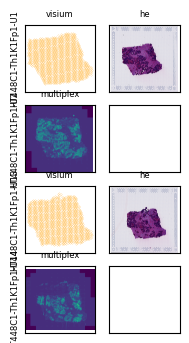

In [534]:
bigwarp.display_data_map(data_map, multiplex_channel=multiplex_channel, gamma=.5)

In [535]:
output_dir = os.path.join(reg_dir, 'unregistered_tifs') # where to write un-registered images to use with bigwarp
Path(output_dir).mkdir(parents=True, exist_ok=True)
output_dir

'/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registration/unregistered_tifs'

In [536]:
# image saving for each data type

def write_st(filepath, output_filepath, dtype, scale=.1):
    if dtype == 'visium':
        adata = visium.adata_from_visium(filepath)
    elif dtype == 'xenium':
        adata = xenium.adata_from_xenium(filepath)
    elif dtype == 'cosmx':
        adata = cosmx.adata_from_cosmx(filepath)
    else:
        raise RuntimeError(f'{dtype} not valid st data type')

    image_data = next(iter(adata.uns['spatial'].values()))
    
    img = image_data['images']['hires'] # grab image
    
    # need to adjust scale by tissue_hires_scalef because spot/cell coordinates are at a different resolution than the image
    sf = scale / image_data['scalefactors']['tissue_hires_scalef']
    
    dim_order = 'h w' if dtype in ['xenium', 'cosmx'] else 'h w c'
    img = utils.rescale(img, scale=sf, dim_order=dim_order, target_dtype=np.uint8) # scale image    
    
    tifffile.imwrite(output_filepath, img, compression='LZW') # write scaled H&E


def write_multiplex(filepath, output_filepath, channel='DAPI', scale=.1):
    # extract OME-TIF
    channel_to_img = multiplex.extract_ome_tiff(
        filepath, channels=[channel], scale=scale
    )
    
    # conversion to uint8
    img = channel_to_img[channel]
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        img /= img.max() # just use max intensity bc not sure what data type range we'll be dealing with
        img *= 255.
        img = img.astype(np.uint8)
    tifffile.imwrite(output_filepath, img, compression='LZW')
    

def write_he(filepath, output_filepath, scale=.1):
    img = he.read_he(filepath, scale=scale)

    tifffile.imwrite(output_filepath, img, compression='LZW')

In [537]:
for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    mapping = item['data'][0] # use first data type for registration by default
    dtype, filepath = mapping['dtype'], mapping['filepath']
    print(sid, dtype)

    output_filepath = os.path.join(output_dir, f's{idx}_{sid}.tif')

    scale = dtype_to_scale.get(dtype, default_scale)
    if utils.parse_dtype(dtype) in ['visium', 'cosmx', 'xenium']:
        write_st(filepath, output_filepath, dtype, scale=scale)
    elif utils.parse_dtype(dtype) == 'multiplex':
        write_multiplex(filepath, output_filepath, channel=multiplex_channel, scale=scale)
    elif utils.parse_dtype(dtype) == 'he':
        write_he(filepath, output_filepath, scale=scale)
    else:
        raise RuntimeError(f'{dtype} is not a valid data type identifier')

HT448C1-Th1K1Fp1-U1 visium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


HT448C1-Th1K1Fp1-U2 multiplex
HT448C1-Th1K1Fp1-U13 visium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


HT448C1-Th1K1Fp1-U14 multiplex


In [538]:
sorted(utils.listfiles(output_dir))

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registration/unregistered_tifs/s0_HT448C1-Th1K1Fp1-U1.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registration/unregistered_tifs/s1_HT448C1-Th1K1Fp1-U2.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registration/unregistered_tifs/s2_HT448C1-Th1K1Fp1-U13.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registration/unregistered_tifs/s3_HT448C1-Th1K1Fp1-U14.tif']

## post bigwarp registration

In [539]:
registered_dir = os.path.join(project_dir, case, 'registered') # this is where we will put our registered data for each section
Path(registered_dir).mkdir(parents=True, exist_ok=True)

In [540]:
fps = sorted(utils.listfiles(reg_dir, regex=r'ddf.tif$'))
fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registration/s1_HT448C1-Th1K1Fp1-U2_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registration/s2_HT448C1-Th1K1Fp1-U13_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registration/s3_HT448C1-Th1K1Fp1-U14_ddf.tif']

In [541]:
target_sid = data_map['target_sid']

sid_to_ddf = {}

for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    mapping = item['data'][0]
    dtype, filepath = mapping['dtype'], mapping['filepath']
    scale = dtype_to_scale.get(dtype, default_scale)
    
    if sid != target_sid: # initial registration target section will not have ddf
        ddf_fp = os.path.join(reg_dir, f's{idx}_{sid}_ddf.tif')

        assert os.path.exists(ddf_fp), f'Expected a warp field file at {ddf_fp}, but no file was found.'
        ddf = bigwarp.read_bigwarp_warp_field(ddf_fp, scale) # ddfs are (c h w)
        sid_to_ddf[sid] = ddf

sid_to_ddf.keys()

dict_keys(['HT448C1-Th1K1Fp1-U2', 'HT448C1-Th1K1Fp1-U13', 'HT448C1-Th1K1Fp1-U14'])

In [542]:
registered_data_map = copy.deepcopy(data_map)

res = data_map['resolution']

for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    for m_idx, mapping in enumerate(item['data']):
        dtype, fp = mapping['dtype'], mapping['filepath']
        print(sid, dtype, fp)
        
        dtype_root = utils.parse_dtype(dtype)
        section_id = f's{idx}_{sid}'
        ddf = sid_to_ddf.get(sid)
        
        if dtype_root == 'he':
            img = he.read_he(fp)
            img = rearrange(img, 'h w c -> c h w') # channel dim must be first
#             print(img.shape, ddf.shape)

            if ddf is not None:
                img = bigwarp.register_he(img, ddf)

            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.tif')
            tifffile.imwrite(
                output_filepath,
                data=rearrange(img, 'c h w -> h w c'),
                resolution=(res, res),
                compression='LZW',
                metadata={
                    'axes': 'YXC',
                    'unit': 'um', # assumes microns as unit
                }
            )
        elif dtype_root == 'visium':
            adata = visium.adata_from_visium(fp)

            if ddf is not None:
                adata = bigwarp.register_visium(
                    adata, ddf, resolution=res
                )
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
            adata.write_h5ad(output_filepath)
        elif dtype_root == 'xenium':
            adata = xenium.adata_from_xenium(fp)
            if ddf is not None:
                adata = bigwarp.register_xenium(
                    adata, ddf, resolution=res
                )
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
            adata.write_h5ad(output_filepath)
        elif dtype_root == 'cosmx':
            adata = cosmx.adata_from_cosmx(fp)
            if ddf is not None:
                adata = bigwarp.register_cosmx(
                    adata, ddf, resolution=res
                )
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
            adata.write_h5ad(output_filepath)
        elif dtype_root == 'multiplex':
            channels, data = multiplex.extract_ome_tiff(fp, as_dict=False)
            if ddf is not None:
                data = bigwarp.register_multiplex(data, ddf)
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.ome.tiff')
            multiplex.write_basic_ome_tiff(
                output_filepath,
                data, channels, pix_per_micron=res
            )
        
        registered_data_map['sections'][idx]['data'][m_idx]['filepath'] = output_filepath

HT448C1-Th1K1Fp1-U1 visium /diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT448C1/Th1K1/HT448C1-Th1K1Fp1U1Bp1/outs


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


HT448C1-Th1K1Fp1-U1 he /diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT448C1-Th1K1Fp1U1.tif
HT448C1-Th1K1Fp1-U2 multiplex /diskmnt/primary/CODEX/HTAN/041323_CRC_HT488C1-Th1K1Fp1-U2/HT488C1-Th1K1Fp1__20230413.ome.tiff
HT448C1-Th1K1Fp1-U13 visium /diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT448C1/Th1K1/HT448C1-Th1K1Fp1U13Bp1/outs


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versio

HT448C1-Th1K1Fp1-U13 he /diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_HT448C1-Th1K1Fp1U13.tif
HT448C1-Th1K1Fp1-U14 multiplex /diskmnt/primary/CODEX/HTAN/041823_CRC_HT488C1-Th1K1Fp1-U14/HT488C1-Th1K1Fp1-U14__20230419.ome.tiff


HT448C1-Th1K1Fp1-U1 visium
HT448C1-Th1K1Fp1-U1 he
HT448C1-Th1K1Fp1-U2 multiplex
HT448C1-Th1K1Fp1-U13 visium
HT448C1-Th1K1Fp1-U13 he
HT448C1-Th1K1Fp1-U14 multiplex


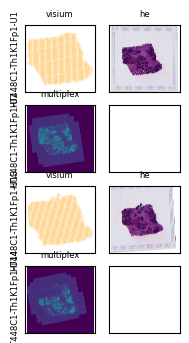

In [543]:
bigwarp.display_data_map(registered_data_map, multiplex_channel=multiplex_channel, gamma=.5)

## save registration metadata

In [544]:
yaml.safe_dump(registered_data_map, open(os.path.join(registered_dir, 'metadata.yaml'), 'w'))

In [545]:
# just viewing
yaml.safe_dump(registered_data_map, sys.stdout)

resolution: 2.320742392851537
sections:
- data:
  - dtype: visium
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s0_HT448C1-Th1K1Fp1-U1_visium.h5ad
  - dtype: he
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s0_HT448C1-Th1K1Fp1-U1_he.tif
  position: 0
  sid: HT448C1-Th1K1Fp1-U1
- data:
  - dtype: multiplex
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s1_HT448C1-Th1K1Fp1-U2_multiplex.ome.tiff
  position: 5
  sid: HT448C1-Th1K1Fp1-U2
- data:
  - dtype: visium
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s2_HT448C1-Th1K1Fp1-U13_visium.h5ad
  - dtype: he
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s2_HT448C1-Th1K1Fp1-U13_he.tif
  position: 60
  sid: HT448C1-Th1K1Fp1-U